In [1]:
import copy
import pytest
import random
import matplotlib.pylab as plt
import numpy as np


AMM = {'USDT': (100000, 100000), 'DAI': (100000, 100000), 'ETH': (100000, 25), 'DOT': (100000, 3000)}
tokens = list(AMM.keys())
init_spot_prices = {}
for k in AMM:
    init_spot_prices[k] = AMM[k][0]/AMM[k][1]
trades = []
max_trade_vol = 0.0001
repeats = 100

for t1 in tokens:
    for t2 in tokens:
        if t2 != t1:
            for i in range(repeats):
                trades.append({
                    'trade': 'buy', 'asset_spec': t1, 'asset_unspec': t2, 'asset_amount': random.random()*AMM[t1][1]*max_trade_vol
                })
                trades.append({
                    'trade': 'sell', 'asset_spec': t1, 'asset_unspec': t2, 'asset_amount': random.random()*AMM[t1][1]*max_trade_vol
                })

#trades = []
#t1 = 'ETH'
#t2 = 'DAI'
#trades.append({
#    'trade': 'buy', 'asset_spec': t1, 'asset_unspec': t2, 'asset_amount': random.random()*AMM[t1][1]*max_trade_vol
#})
#trades.append({
#    'trade': 'sell', 'asset_spec': t1, 'asset_unspec': t2, 'asset_amount': random.random()*AMM[t1][1]*max_trade_vol
#})

random.shuffle(trades)

In [2]:


# xyk equation
def delta_x_given_delta_y(x, y, delta_y):
    return -x*delta_y/(y + delta_y)

def calc_invariant(AMM, asset):
    return AMM[asset][0] * AMM[asset][1]

def execute_LHDX_trade(trade, AMM):
    new_AMM = copy.deepcopy(AMM)
    if trade['asset_spec'] == 'LHDX':
        Qj, Rj = AMM[trade['asset_unspec']]
        delta_Qj = trade['asset_amount'] * (1 if trade['trade'] == 'sell' else -1)
        assert delta_Qj + Qj > 0
        delta_Rj = delta_x_given_delta_y(Rj, Qj, delta_Qj)
        new_AMM[trade['asset_unspec']] = (Qj + delta_Qj, Rj + delta_Rj)
        assert calc_invariant(new_AMM, trade['asset_unspec']) == pytest.approx(calc_invariant(AMM, trade['asset_unspec']))
    elif trade['asset_unspec'] == 'LHDX':
        Qi, Ri = AMM[trade['asset_spec']]
        delta_Ri = trade['asset_amount'] * (1 if trade['trade'] == 'sell' else -1)
        assert delta_Ri + Ri > 0
        delta_Qi = delta_x_given_delta_y(Qi, Ri, delta_Ri)
        new_AMM[trade['asset_spec']] = (Qi + delta_Qi, Ri + delta_Ri)
        assert calc_invariant(new_AMM, trade['asset_spec']) == pytest.approx(calc_invariant(AMM, trade['asset_spec']))
    else:
        raise
    return new_AMM

def execute_trade(trade, AMM):
    new_AMM = copy.deepcopy(AMM)
    if 'LHDX' in [trade['asset_spec'], trade['asset_unspec']]:
        new_AMM = execute_LHDX_trade(trade, AMM)
    else:
        trade1 = copy.deepcopy(trade)
        trade1['asset_unspec'] = 'LHDX'
        new_AMM = execute_LHDX_trade(trade1, AMM)
        delta_Q = abs(AMM[trade['asset_spec']][0] - new_AMM[trade['asset_spec']][0])
        trade2 = copy.deepcopy(trade)
        trade2['asset_spec'] = 'LHDX'
        trade2['asset_amount'] = delta_Q
        new_AMM = execute_LHDX_trade(trade2, new_AMM)
    return new_AMM, {
        trade['asset_spec']: trade['asset_amount'] * (1 if trade['trade'] == 'buy' else -1),
        trade['asset_unspec']: AMM[trade['asset_unspec']][1] - new_AMM[trade['asset_unspec']][1]}

def get_slippage(trade, trade_deltas, init_spot_prices):
    if trade['trade'] == 'buy':
        asset_out_amt = trade['asset_amount']
        asset_out = trade['asset_spec']
        asset_in_amt = abs(trade_deltas[trade['asset_unspec']])
        asset_in = trade['asset_unspec']
        slippage = asset_out_amt/(asset_in_amt * init_spot_prices[asset_in]/init_spot_prices[asset_out]) - 1
    else:
        asset_out_amt = abs(trade_deltas[trade['asset_unspec']])
        asset_out = trade['asset_unspec']
        asset_in_amt = trade['asset_amount']
        asset_in = trade['asset_spec']
        slippage = asset_out_amt/(asset_in_amt * init_spot_prices[asset_in]/init_spot_prices[asset_out]) - 1
    return slippage

def get_exec_price(trade_deltas, numeraire_tkn, other_tkn):
    return -trade_deltas[numeraire_tkn]/trade_deltas[other_tkn] if numeraire_tkn < other_tkn else -trade_deltas[other_tkn]/trade_deltas[numeraire_tkn]

def get_price_key(trade):
    return (trade['asset_unspec'], trade['asset_spec']) if trade['asset_unspec'] < trade['asset_spec'] else (trade['asset_spec'], trade['asset_unspec'])

def get_deltas_from_prices(trade, exec_prices):
    trade_deltas = {}
    i = tokens.index(trade['asset_spec'])
    j = tokens.index(trade['asset_unspec'])
    Pji = exec_prices[i]/exec_prices[j]

    if trade['trade'] == 'buy':
        trade_deltas[trade['asset_spec']] = trade['asset_amount']
        trade_deltas[trade['asset_unspec']] = -Pji * trade['asset_amount']
    else:
        trade_deltas[trade['asset_spec']] = -trade['asset_amount']
        trade_deltas[trade['asset_unspec']] = trade['asset_amount'] *Pji
    return trade_deltas
    



## No order batching

In [3]:
trade_results = []
all_slippage = []
exec_prices = {}
for trade in trades:
    AMM, trade_deltas = execute_trade(trade, AMM)
    slippage = get_slippage(trade, trade_deltas, init_spot_prices)
    trade_results.append((trade, trade_deltas, slippage))
    all_slippage.append(slippage)
    key = get_price_key(trade)
    if key not in exec_prices:
        exec_prices[key] = []
    exec_prices[key].append(get_exec_price(trade_deltas, trade['asset_spec'], trade['asset_unspec']))

    


## Full order batching

In [4]:
full_tokens = ['LHDX'] + tokens
n = len(tokens)
delta_K = [[0]*n for i in range(n)]
delta_K0i = [0]*n
delta_Ki0 = [0]*n
for trade in trades:
    if trade['asset_spec'] != 'LHDX':
        j = tokens.index(trade['asset_spec'])
    if trade['asset_unspec'] != 'LHDX':
        i = tokens.index(trade['asset_unspec'])
    if 'LHDX' not in (trade['asset_spec'], trade['asset_unspec']):
        delta_K[i][j] += trade['asset_amount']
    elif trade['asset_spec'] == 'LHDX':
        delta_K0i[i] += trade['asset_amount']
    else:
        delta_Ki0[j] += trade['asset_amount']

M = [None]*n
for i in range(n):
    Mi = [None]*n
    for j in range(n):
        delta_Kj = sum([delta_K[ij][j] for ij in range(n)]) + delta_Ki0[j]
        Mi[j] = -delta_K[i][j]/(AMM[tokens[j]][1] + delta_Kj) if i != j else 1
    M[i] = Mi
A = np.array(M)
inv_A = np.linalg.inv(A)

Q = np.array([AMM[tkn][0] for tkn in tokens])
X = inv_A.dot(Q)
P = [X[i] / (AMM[tokens[i]][1] + sum([delta_K[ij][i] for ij in range(n)])) for i in range(n)]
print(P)

batched_slippage = []
for trade in trades:
    trade_deltas = get_deltas_from_prices(trade, P)
    slippage = get_slippage(trade, trade_deltas, init_spot_prices)
    batched_slippage.append(slippage)




[1.003984072986878, 0.9980608657436746, 3987.978378821564, 33.36557063164365]


## Pairwise order batching

In [5]:
Q = [AMM[tokens[i]][0] for i in range(len(tokens))]
R = [AMM[tokens[i]][1] for i in range(len(tokens))]


('DAI', 'ETH')
3995.7266292071713


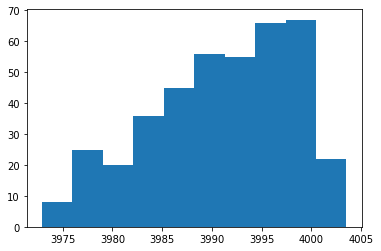

('DOT', 'ETH')
119.523757673708


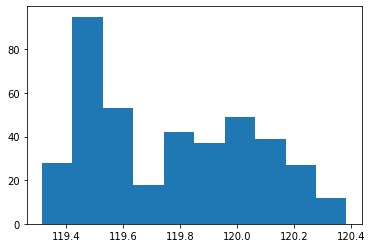

('DOT', 'USDT')
0.030090421173097136


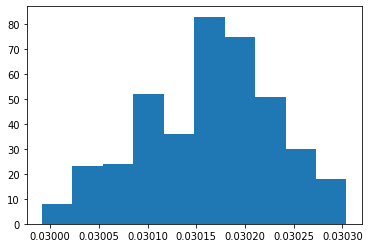

('DAI', 'USDT')
1.0059347154532403


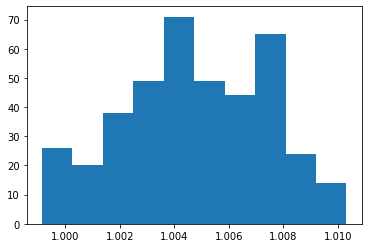

('DAI', 'DOT')
33.43039665900768


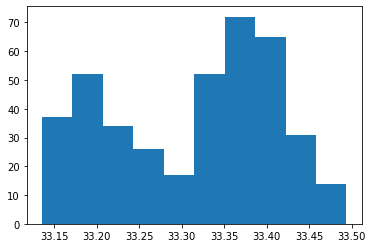

('ETH', 'USDT')
0.0002517526369547551


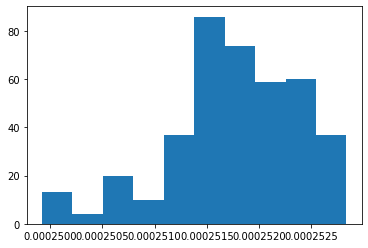

{'USDT': (100265.12250985972, 99735.57853097559), 'DAI': (99899.28612764622, 100100.81540745433), 'ETH': (99842.12268424094, 25.039531740590682), 'DOT': (99993.46867825312, 3000.19595245069)}
[1.0053094791917176, 0.9979867368813351, 3987.3797848380077, 33.32897926102931]


In [6]:
for key in exec_prices:
    print(key)
    tkn1 = key[0]
    tkn2 = key[1]
    i = tokens.index(tkn1)
    j = tokens.index(tkn2)
    batch_price = P[j]/P[i]
    print(batch_price)
    plt.hist(exec_prices[key])
    plt.show()
    
    
print(AMM)
P = [AMM[tkn][0]/AMM[tkn][1] for tkn in AMM]
print(P)


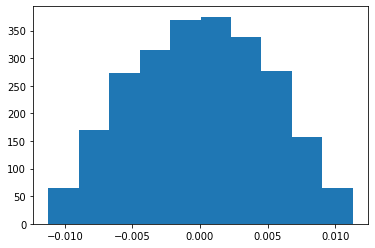

In [7]:
plt.hist(all_slippage)
plt.show()

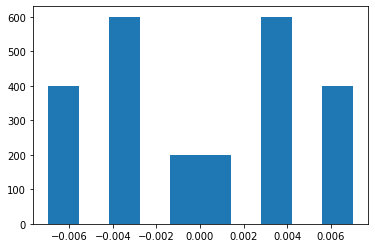

In [8]:
plt.hist(batched_slippage)
plt.show()